## Imports

> **Note:** In this notebook, we are extendng the training data to try and increase the model accuracy on unseen data when published.

Datasets:
* [Emotion Dataset for NLP](https://www.kaggle.com/code/kushagrakesarwani/sentiment-analysis/input)
* [Emotions](https://www.kaggle.com/datasets/nelgiriyewithana/emotions) from Kaggle is explored as an option to extend the dataset.
* 

In [33]:
import gradio as gr
import pandas as pd
import tensorflow as tf
import seaborn as sns
import numpy as np
import spacy
import csv
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from timeit import default_timer as timer
from helper_functions import plot_pie_chart, preprocess_text, plot_training_history, preprocess_single_sentence
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# DIR= 'kaggle/input/emotion-dataset-for-nlp/'
# TRAIN_FILE = 'train.txt'
# VAL_FILE = 'val.txt'
# TEST_FILE = 'test.txt'
# EMOTION_FILE= 'kaggle/input/Emotion_classify_Data.csv'
# EMOTIONS_DATASET= 'kaggle/input/text.csv'

In [3]:
# train_df = pd.read_csv(DIR+TRAIN_FILE, delimiter=';', header=None, names=['text', 'label'], dtype=str)
# val_df = pd.read_csv(DIR+VAL_FILE, delimiter=';', header=None, names=['text', 'label'], dtype=str)
# test_df = pd.read_csv(DIR+TEST_FILE, delimiter=';', header=None, names=['text', 'label'], dtype=str)
# df= pd.read_csv(EMOTIONS_DATASET, delimiter=',', header=None, names=['text', 'label'], dtype=str)

In [4]:
# df.reset_index(drop=True, inplace=True)
# df.drop(index=0, inplace=True)
# df.head()

## Preprocessing

In [5]:
# emotions_dataset_label = {'0': 'sadness', 
#                           '1': 'joy', 
#                           '2': 'love', 
#                           '3': 'anger', 
#                           '4': 'fear', 
#                           '5': 'surprise'}

# df['label'] = df['label'].replace(emotions_dataset_label)
# new_df= pd.concat([df, train_df, val_df, test_df])
# del(df, train_df, test_df, val_df)

In [6]:
# new_df.info()

In [7]:
# new_df['label']= new_df['label'].str.replace('love', 'joy')
# new_df['label'].value_counts()

In [8]:
# X_train, X_counter, y_train, y_counter = train_test_split(new_df['text'], new_df['label'], test_size=0.2, random_state=42)
# X_test, X_val, y_test, y_val = train_test_split(X_counter, y_counter, test_size=0.5, random_state=42)
# del (X_counter, y_counter)

In [9]:
# train_df = pd.DataFrame({'text': X_train, 'label': y_train}).reset_index(drop=True)
# test_df= pd.DataFrame({'text': X_test, 'label': y_test}).reset_index(drop=True)
# val_df= pd.DataFrame({'text': X_val, 'label': y_val}).reset_index(drop=True)

In [10]:
# train_df= preprocess_text(train_df)
# test_df= preprocess_text(test_df)
# val_df= preprocess_text(val_df)

In [11]:
# train_df.to_csv('kaggle/train.txt', index= False, header= None)
# test_df.to_csv('kaggle/test.txt', index= False, header= None)
# val_df.to_csv('kaggle/valid.txt', index= False, header= None)

In [12]:
train_df= pd.read_csv('kaggle/train.txt', names=['processed_text', 'label_num'])
test_df= pd.read_csv('kaggle/test.txt', names=['processed_text', 'label_num'])
val_df= pd.read_csv('kaggle/valid.txt', names=['processed_text', 'label_num'])

In [13]:
train_df.head()

,processed_text,label_num
0,not feel angry,0
1,look guy play england feel jealous aiden mcgea...,0
2,thing mean understand feel foolish,3
3,feel gentle press seed soil,2
4,live city constantly feel disadvantaged don t ...,3


In [14]:
encoder= LabelEncoder()
encoder.fit(train_df['label_num'])
labels= encoder.classes_
labels

array([0, 1, 2, 3])

In [15]:
class_weights= compute_class_weight('balanced', classes=labels, y= train_df['label_num'])
class_weights= dict(enumerate(class_weights))
class_weights

{0: 1.7538883567918715,
 1: 2.104683556954751,
 2: 0.5722304118038667,
 3: 0.8283908305961489}

## Visualisation

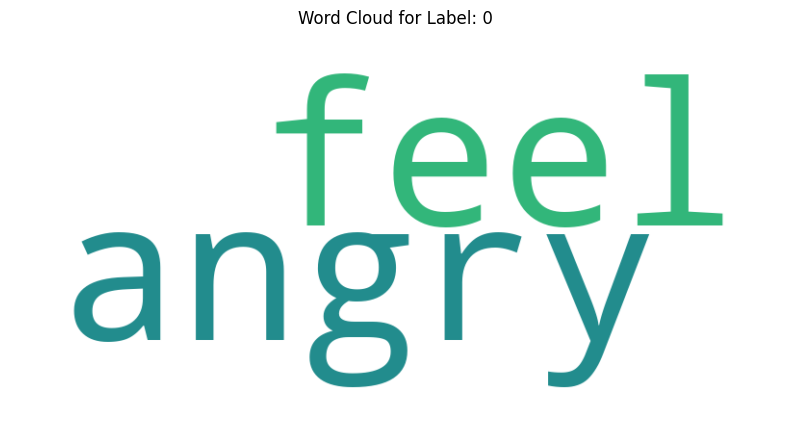

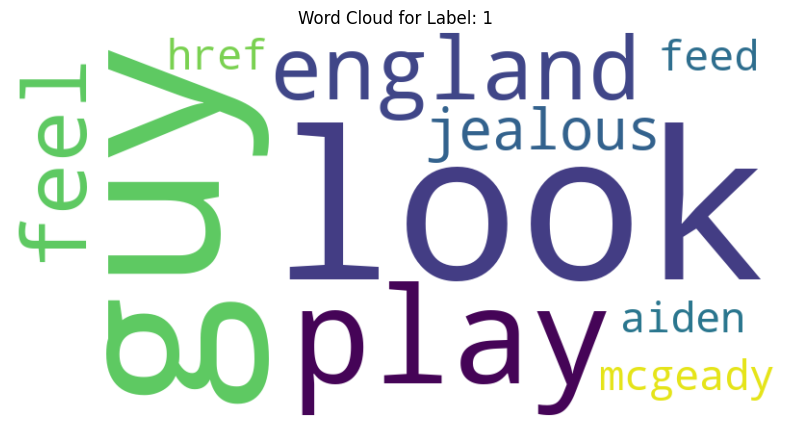

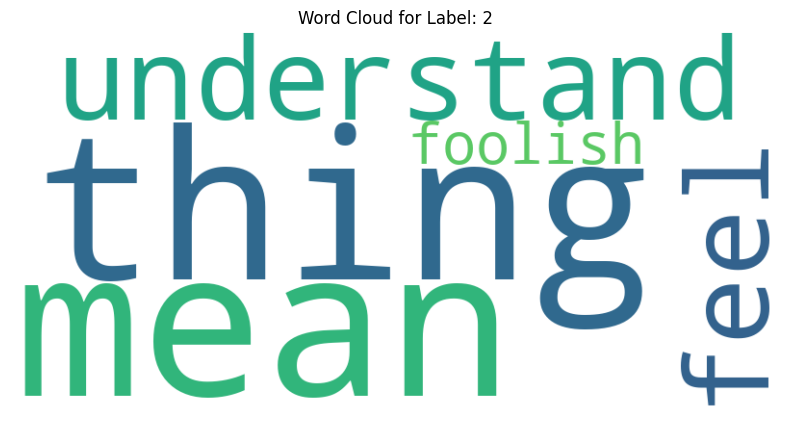

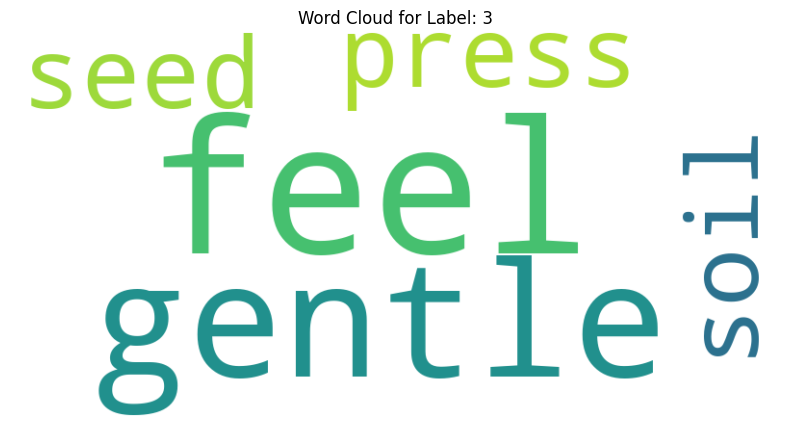

In [16]:
# Generate and plot word cloud for each label
for class_label, text in zip(labels, train_df['processed_text']):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Label: {class_label}')
    plt.axis('off')
    plt.show()


## Model

In [17]:
VOCAB_SIZE= 40000
text_vect_layer= tf.keras.layers.TextVectorization(max_tokens= VOCAB_SIZE)
text_vect_layer.adapt(train_df['processed_text'].astype(str))

In [18]:
EMBEDDING_UNITS= 64
UNITS= 32
DROPOUT= 0.2

model_v1= tf.keras.Sequential([
    text_vect_layer,
    layers.Embedding(input_dim= text_vect_layer.vocabulary_size(), output_dim= EMBEDDING_UNITS, mask_zero= True),
    layers.GRU(UNITS, dropout= DROPOUT, return_sequences= False),
    layers.Dense(len(labels), activation= 'softmax')
])

model_v2= tf.keras.Sequential([
    text_vect_layer,
    layers.Embedding(input_dim= text_vect_layer.vocabulary_size(), output_dim= EMBEDDING_UNITS, mask_zero= True),
    layers.LSTM(UNITS, dropout= DROPOUT),
    layers.Dense(len(labels), activation= 'softmax')
])


In [19]:
model_v1.compile(optimizer= tf.keras.optimizers.Adam(),
                 loss= tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics=['accuracy'])
model_v2.compile(optimizer= tf.keras.optimizers.Adam(),
                 loss= tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics=['accuracy'])


In [20]:
GRU_MODEL= 'models/gru_model.keras'
LSTM_MODEL= 'models/lstm_model.keras'

gru_checkpoint_callback = ModelCheckpoint(filepath=GRU_MODEL,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      mode='max',
                                      verbose=1)

lstm_checkpoint_callback = ModelCheckpoint(filepath=LSTM_MODEL,
                                           monitor='val_accuracy',
                                           save_best_only=True,
                                           mode='max',
                                           verbose=1)

In [21]:
BATCH_SIZE= 128
train_set= tf.data.Dataset.from_tensor_slices((train_df['processed_text'].values.astype(str), train_df['label_num'].values)).batch(BATCH_SIZE)
test_set= tf.data.Dataset.from_tensor_slices((test_df['processed_text'].values.astype(str), test_df['label_num'].values)).batch(BATCH_SIZE)
val_set= tf.data.Dataset.from_tensor_slices((val_df['processed_text'].values.astype(str), val_df['label_num'].values)).batch(BATCH_SIZE)

In [22]:
EPOCHS= 10
history_model_v1= model_v1.fit(train_set,
                               validation_data= val_set,
                               epochs= EPOCHS,
                               callbacks= [gru_checkpoint_callback],
                               class_weight= class_weights)

Epoch 1/10
2630/2633 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8649 - loss: 0.3846
Epoch 1: val_accuracy improved from -inf to 0.96376, saving model to models/gru_model.keras
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - accuracy: 0.8650 - loss: 0.3843 - val_accuracy: 0.9638 - val_loss: 0.0880
Epoch 2/10
2632/2633 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9664 - loss: 0.0826
Epoch 2: val_accuracy improved from 0.96376 to 0.96616, saving model to models/gru_model.keras
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.9664 - loss: 0.0826 - val_accuracy: 0.9662 - val_loss: 0.0780
Epoch 3/10
2630/2633 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9706 - loss: 0.0697
Epoch 3: val_accuracy improved from 0.96616 to 0.96651, saving model to models/gru_model.keras
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - accuracy: 0.9706 - loss: 0.0697 - val_accuracy: 0.9665 - val_loss: 0.0775
Epoch 4/10
2629/2633 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9725 - loss: 0.0644

In [23]:
history_model_v2= model_v2.fit(train_set,
                               validation_data= val_set, 
                               epochs= EPOCHS,
                               callbacks= [lstm_checkpoint_callback],
                               class_weight= class_weights)

Epoch 1/10
2632/2633 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8724 - loss: 0.4025
Epoch 1: val_accuracy improved from -inf to 0.96136, saving model to models/lstm_model.keras
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 33s 12ms/step - accuracy: 0.8725 - loss: 0.4023 - val_accuracy: 0.9614 - val_loss: 0.0944
Epoch 2/10
2631/2633 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9652 - loss: 0.0853
Epoch 2: val_accuracy improved from 0.96136 to 0.96525, saving model to models/lstm_model.keras
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - accuracy: 0.9652 - loss: 0.0853 - val_accuracy: 0.9653 - val_loss: 0.0804
Epoch 3/10
2629/2633 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9701 - loss: 0.0709
Epoch 3: val_accuracy did not improve from 0.96525
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.9701 - loss: 0.0709 - val_accuracy: 0.9640 - val_loss: 0.0821
Epoch 4/10
2630/2633 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9724 - loss: 0.0645
Epoch 4: val_accuracy did not improve fro

## Plotting the losses and accuracy

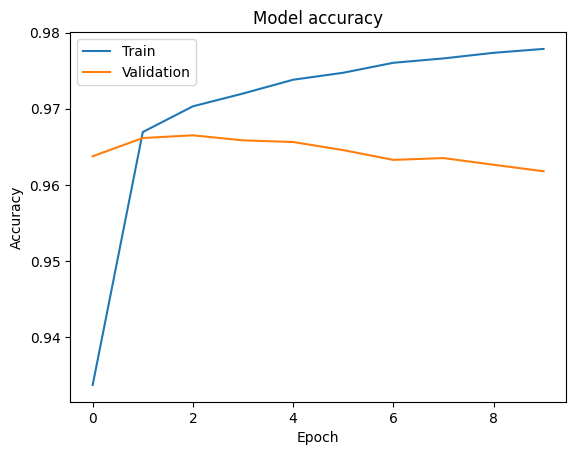

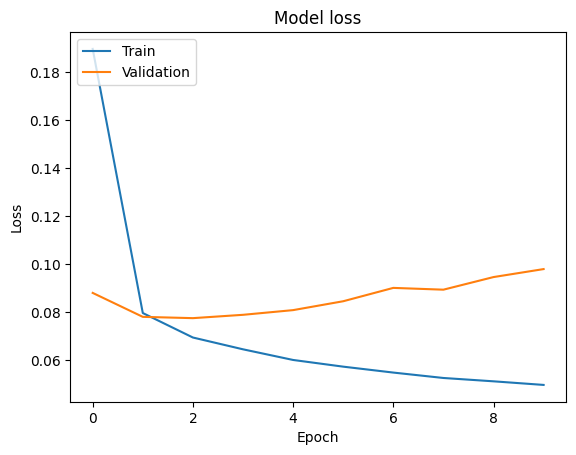

In [24]:
plot_training_history(history_model_v1)

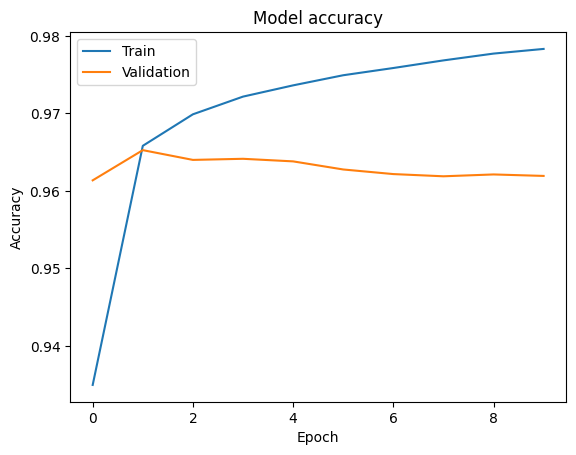

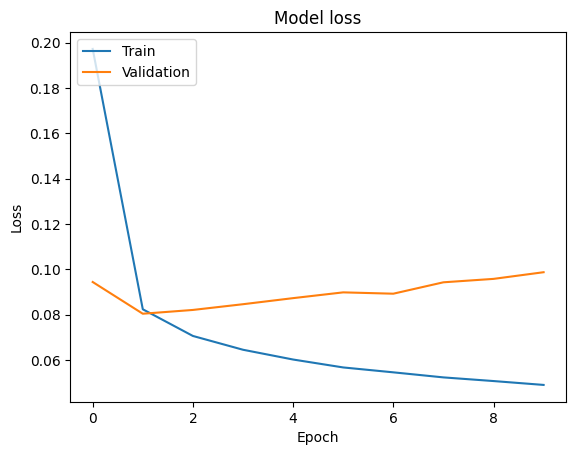

In [25]:
plot_training_history(history_model_v2)

## Evaluate the model

In [26]:
test_loss, test_acc= model_v1.evaluate(test_set)

329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9603 - loss: 0.0985


In [27]:
def evaluate_true_vs_predicted(true_labels, predicted_labels):
    """
    Evaluates the true versus predicted labels using accuracy and confusion matrix.

    Parameters:
    true_labels (numpy array): Array containing true labels.
    predicted_labels (numpy array): Array containing predicted labels.

    Returns:
    accuracy (float): Accuracy of the predictions.
    confusion_mat (numpy array): Confusion matrix.
    """
    accuracy = accuracy_score(true_labels, predicted_labels)
    confusion_mat = confusion_matrix(true_labels, predicted_labels)
    return accuracy, confusion_mat

In [28]:
del(model_v1, model_v2)

In [29]:
model_v1 = tf.keras.models.load_model(GRU_MODEL)

In [53]:
test_df.reset_index(drop=True, inplace=True)
true_labels= test_df['label_num']
test_df.head()

,processed_text,label_num
0,afraid leave relationship feel belong afraid s...,1
1,not help feel indie ask trouble receive rude t...,0
2,buy book people feel equally fuck book zen app...,0
3,m feel little heartbroken penguin m sure ill,3
4,feel divine,2


In [ ]:
# pred_labels= []
# true_labels= test_df['label_num']

# for i in range(len(true_labels)):
#     sample_text= test_df['processed_text'][i]
#     sample_text= tf.expand_dims(sample_text, 0)
#     prob= model_v1.predict(sample_text)
#     prob= prob[0]
#     pred_label= np.argmax(prob)
#     pred_labels.append(pred_label)

In [ ]:
# accuracy, confusion_mat = evaluate_true_vs_predicted(true_labels, predicted_labels=pred_labels)
# print(f"Accuracy: {accuracy:.4f}")

In [ ]:
# plt.figure(figsize=(12,8))
# sns.heatmap(confusion_mat, annot=True, cmap='coolwarm')
# plt.title('Confusion matrix')
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.show()

In [ ]:
# comparison_df = pd.DataFrame({
#     'True_Label': encoder.inverse_transform(true_labels),
#     'Predicted_Label': encoder.inverse_transform(pred_labels),
#     'Text': test_df['processed_text'] 
# })

# wrong_predictions_df = comparison_df[comparison_df['True_Label'] != comparison_df['Predicted_Label']]

# print("Wrongly Predicted Labels vs. True Labels:")
# wrong_predictions_df

## Predictions for a single sentence
To make predictions on a single sentence, we need to do the following steps:
1. Process it in the same manner to remove the extra token words such (as punctuations)
2. Expand the dimension.
3. Pass through the model.

In [44]:
with open('kaggle/examples.txt', 'r') as f:
    example_list = [example.strip() for example in f.readlines()]

with open('kaggle/label_names.txt', 'r') as f:
    labels = [label.strip() for label in f.readlines()]

encoder = LabelEncoder()
encoder.fit(labels) 

def predict(text):
    """
    Make predictions on the given text using the trained model.

    Args:
        text (str): The text to make predictions on.

    Returns:
        list: A list of predictions.
    """
    start_time = timer()
    processed_text = preprocess_single_sentence(text)
    text_tensor = tf.expand_dims(processed_text, 0)

    probability = model_v1.predict(text_tensor)
    pred_label_with_prob = {labels[i]: float(probability[0][i]) for i in range(len(labels))} 
    pred_time = round(timer() - start_time, 5)

    with open('kaggle/output/new_text.txt', 'a') as csvfile:
        field_names = ['Text', 'Label']
        writer = csv.DictWriter(csvfile, fieldnames=field_names)

        # Write header if file is empty
        if csvfile.tell() == 0:
            writer.writeheader()

        writer.writerow({'Text': text, 'Label': encoder.inverse_transform([probability.argmax()])[0]})

    return pred_label_with_prob, pred_time

### Gradio App
input = gr.Textbox(lines=5, label="Enter text", placeholder="i like to have the same breathless feeling as a reader eager to see what will happen next")
outputs = [
    gr.Label(num_top_classes=len(labels), label="Predictions"),
    gr.Number(label="Prediction time (s)"),
]
title = 'Sentiment Analysis 🤣😱😡😢'
description = 'The sentiment analysis model is a deep learning-based natural language processing (NLP) model designed to analyze and classify the sentiment expressed in text data. It is trained to understand the emotional tone of text and categorize it into predefined sentiment categories such as <b>anger, fear, sadness, and joy.<b>'
demo = gr.Interface(fn=predict, 
                    inputs=input, 
                    outputs=outputs, 
                    title=title, 
                    description=description,
                    examples=example_list
                   )
demo.launch()


Running on local URL:  http://127.0.0.1:7871

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
